# "Dog Breed Identification"

Pet insurance is a rapidly growing industry in the United States. Pet owners are beginning to purchase policies that
require a monthly premium to de-risk the event of paying for an expensive medical condition or procedure for
their pet down the line. As this space is quickly growing, there are several companies in the market, each looking
to gain an advantage by benefiting consumers.

## Business Understanding

The goal of many insurers, to gain an advantage in the market, is to ease the quote process for customers
purchasing pet insurance. In the current state, they need to supply information such as the pet’s age, gender, and
breed. We believe that all of this information can be determined from a picture. To prove this concept is possible
we would like to be able to predict a dog’s breed with just a photo.

Therefore a model needs to be built that can ingest a picture of a dog and **classify which breed it is most likely to be.** A multi-class classification problem. 

## Data Understanding

*Starts with an initial data collection and proceeds with activities in order to get familiar with the data. The idea here is to identify data quality problems, to discover first insights into the data, and detect interesting subsets to form hypotheses for hidden information.*


In [1]:
# imports
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Paths 
DATA_PATH = 'data/complete/'
MODEL_PATH = 'models/'

In [2]:
def get_image_info(data_path):
    """
    Reads breed name, path to image and gets image shape from data path
    
    Args:
        data_path (Pathlib Path): path to data directory    
    Returns:
        df (pandas df): pandas dataframe with breed name, path to image and image shape
    """
    # Init empty df 
    df = pd.DataFrame(columns=['breed_name', 'filepath', 'image_size'])
    breed_folders = glob.glob(data_path + '/*')
    for breed_folder in breed_folders:
        # Get breed name
        breed_name = breed_folder.split('.')[-1]
        image_files = glob.glob(breed_folder + '/*' )
        for image_filename in image_files:
            # Open image 
            image = PIL.Image.open(image_filename)
            # Append to df 
            df = df.append({'breed_name': breed_name, 'filepath': image_filename, 'image_size': image.size}, 
                                   ignore_index=True)
    return df

df = get_image_info(DATA_PATH)
print('Total Number of Images: {}'.format(len(df)))
print('Total Number of Classes: {}'.format(df.breed_name.nunique()))

Total Number of Images: 8351
Total Number of Classes: 133


### Dog Breed Distribution 

Number of images per class in dataset. Dataset does have a slight imbalance, but nothing terrible

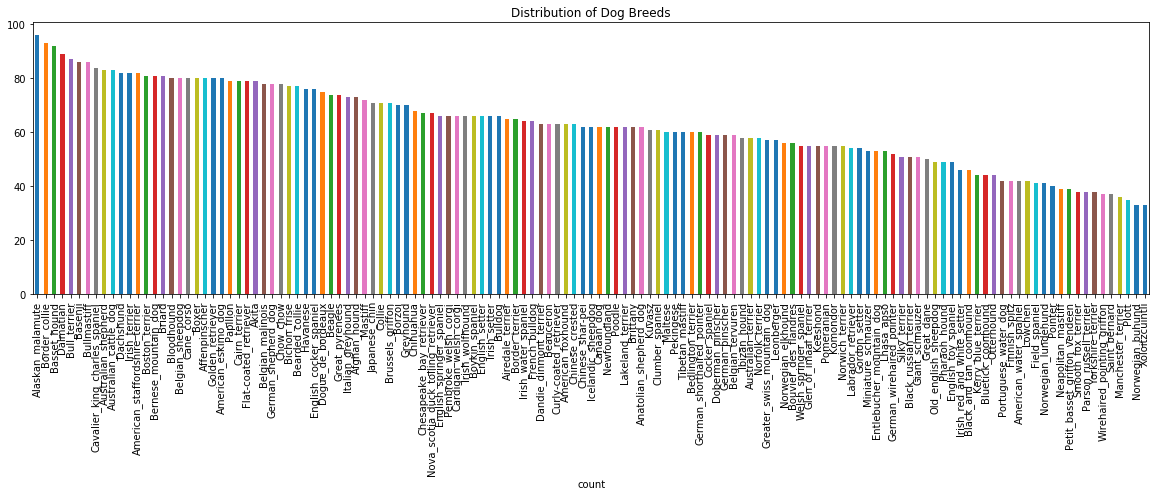

In [3]:
df.breed_name.value_counts().plot(kind='bar', figsize=(20, 5))
plt.xlabel('count')
plt.title('Distribution of Dog Breeds');

### Image Sizes

Seems as most images are around 500 by 500 images with a bunch of outlier images. Since ImageNet is trained on 224 and 299, we will probably stick with these for now. 

In [3]:
heights, widths = zip(*df.image_size.values)
df['height'] = heights
df['width'] = widths

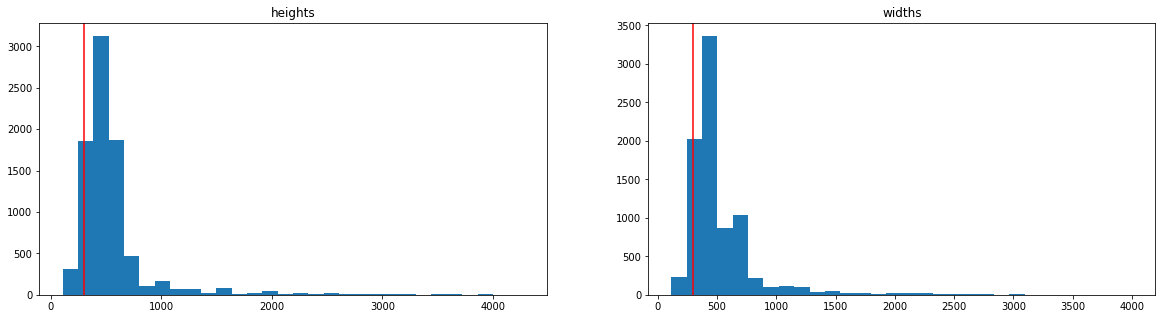

In [4]:
size = 299

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax1.hist(heights, bins=30)
ax1.axvline(size, c='r')
ax1.set_title('heights')
ax2.hist(widths, bins=30)
ax2.axvline(size, c='r')
ax2.set_title('widths');

Data leak test. Could we potentially use the image sizes to predict the breed of the dog? 

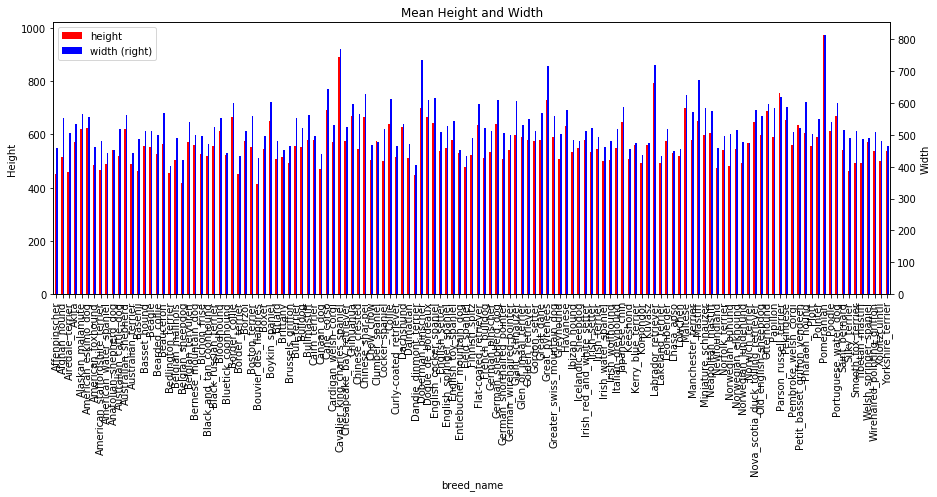

In [7]:
ax = df.groupby('breed_name')[['height', 'width']].mean().plot(kind='bar', secondary_y=['width'], figsize=(15, 5), 
                                                               color=['r', 'b'])
plt.title('Mean Height and Width Per Breed')
ax.set_ylabel('Height')
ax.right_ax.set_ylabel('Width');

In [5]:
def plot_images(image_paths, labels, pred=None):
    """
    Plots 9 images along with the class label 
    Optionally plots the prediction from the model
    
    Args:
        image_paths (list): list of image paths 
        labels (list): list of class names
        pred (list): list of predicted classes from model 
    Returns:
        None
    """
    # Expects 9 images 
    assert len(image_paths) == len(labels) == 9
    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(20, 10))
    # Adjust spacing 
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Show image 
        ax.imshow(PIL.Image.open(image_paths[i]))
        # Name of the true class
        cls_true_name = labels[i]

        # Show true and predicted classes.
        if pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

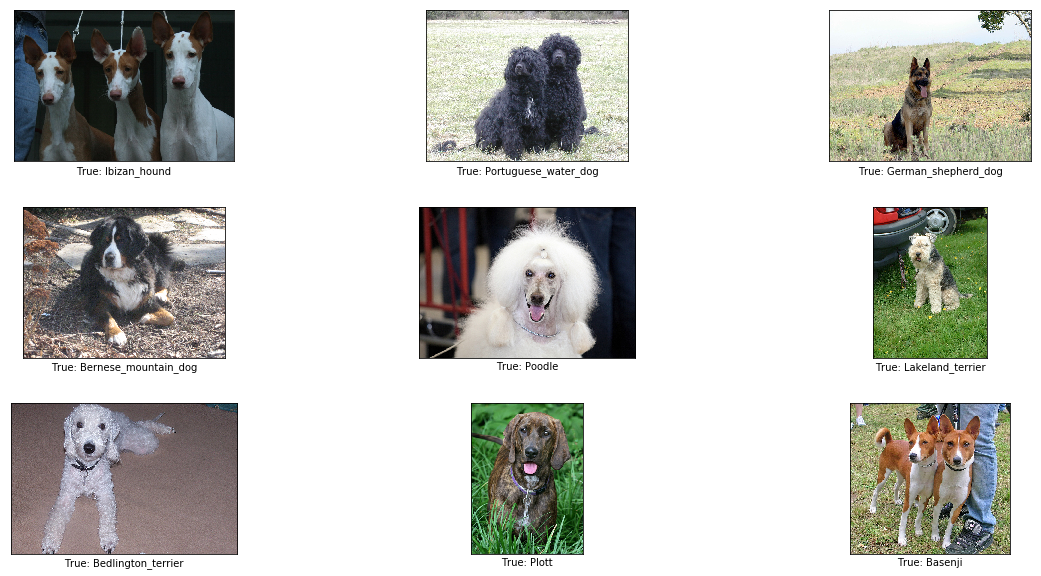

In [6]:
# Show 9 sample images from dataset 
sample = df.sample(9, random_state=100)
plot_images(list(sample.filepath), list(sample.breed_name))

Observations
- Seems like we have some images with multiple dogs
- some very big and some very small images
- different backgrounds
- different objects in the images 
- some images of full dogs and other just of head, etc...

## Data Preparation

*The data preparation phase covers all activities to construct the final dataset from the initial raw data.*

Split dataset into training, validation, and testing folders. We go with an 80 / 10 / 10 split 

In [51]:
import split_folders
split_folders.ratio(DATA_PATH, output='output', seed=100, ratio=(0.8, 0.1, 0.1))
N = len(df)
print('training set size: {}, validation set size: {}, testing set size: {}'.format(round(N*0.8), round(N*0.1), round(N*0.1)))

training set size: 6681, validation set size: 835, testing set size: 835


Connection is already closed.
Connection is already closed.


Load in dataset and perform data transformations. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating. And we also create pytorch datasets and pytorch Dataloaders. 

In [33]:
# torch imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler, SubsetRandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

# CONFIG FILE 
# Imagenet mean and std 
MEAN_IMAGENET = [0.485, 0.456, 0.406]
STD_IMAGENET = [0.229, 0.224, 0.225]
# Device 
DEVICE = 'cuda'

# Transforms for the training, validation, and testing sets
normalize = transforms.Normalize(
    mean=MEAN_IMAGENET, 
    std=STD_IMAGENET)


class GetData:
    """
    Dog Breed Data Class 
    
    Attributes:
        data_path (str): Path the data folder
        batch_size (int): Batch Size
        num_workers (int): Number of workers
    """
    def __init__(self, data_path, batch_size=32, num_workers=4):
        """
        Args:
            data_path (str): Path the data folder
            batch_size (int): Batch Size
            num_workers (int): Number of workers
        """
        self.data_path = data_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def get_transforms(self, size):
        """
        Training and Testing Set Image Transformations
        
        Args:
            size (int): Desired Image Size
        Returns:
            data_transforms (dict): Dictionary of train and test transformations
        """
        data_transforms = {
            'train': transforms.Compose([
                     transforms.RandomResizedCrop(size),
                     transforms.RandomHorizontalFlip(),
#                      transforms.RandomRotation(10),
                     transforms.ColorJitter(0.05, 0.05),
                     transforms.ToTensor(),
                     normalize]),
            'test': transforms.Compose([
                    transforms.Resize(size),
                    transforms.CenterCrop(size),
                    transforms.ToTensor(),
                    normalize])
        }
        return data_transforms
    
    def sampler(self, index):
        """
        Samples elements randomly from a given list of indices, without replacement
        
        Args:
            index (list): Indices to sample from
        """
        return SubsetRandomSampler(index)
    
    def get_image_datasets(self, size):
        """
        Loads image data and applies data transforms in this pyTorch DataSet
        
        Args:
            size (int): Desired Image Size
        Returns:
            image_datasets (dict): Dictionary of train, valid, test pyTorch DataSets
        """
        data_transforms = self.get_transforms(size)
        # Load the datasets with ImageFolder
        image_datasets = {'train': ImageFolder(self.data_path + '/train', 
                                               transform=data_transforms['train']), 
                          'valid': ImageFolder(self.data_path + '/val', 
                                               transform=data_transforms['test']),
                          'test' : ImageFolder(self.data_path + '/test', 
                                               transform=data_transforms['test'])}
        return image_datasets
    
    def get_data_loaders(self, size):
        """
        Create pyTorch DataLoader from pyTorch DataSet 
        
        Args:
            size (int): Desired Image Size
        Returns:
            dataloaders (dict): Dictionary of train, valid, test pyTorch DataLoaders
        """
        # Using the image datasets and the trainforms, define the dataloaders
        image_datasets = self.get_image_datasets(size)
        dataloaders = {'train': DataLoader(image_datasets['train'], shuffle=True,
                                           batch_size=self.batch_size, num_workers=self.num_workers),
                       'valid': DataLoader(image_datasets['valid'], shuffle=False,
                                           batch_size=self.batch_size, num_workers=self.num_workers),
                       'test': DataLoader(image_datasets['test'], shuffle=False,
                                          batch_size=self.batch_size, num_workers=self.num_workers)}
        return dataloaders
    

## Modeling

*The modeling process*

Here, we will use transfer learning with the ResNet50 Model. Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets are trained on huge datasets like ImageNet. So we use a pretrained network as a fixed feature extractor or as an initial network to fine tune. As a start, since this dataset is so 'similar' to the images trained on ImageNet (I think they are directly from ImageNet actually), we set all the ResNet model parameters to not trainable and only train the final FC layer.

In [20]:
def set_trainable_attr(model, b):
    """Set parameters of model be trainable or not trainable"""
    model.trainable = b
    for p in model.parameters(): 
        p.requires_grad = b 
        
class Flatten(nn.Module): 
    """
    Flatten Layer Class
    """
    def __init__(self): 
        super().__init__() 
    def forward(self, X): 
        """Returns flattened tensor"""
        return X.view(X.size(0), -1)
    
class ResNetModel(nn.Module):
    """
    ResNet 50 Model
    
    Attributes:
        layers (Sequential model): pyTorch Sequential model layers 
    """
    def __init__(self, K):
        """
        Builds Resnet model
        
        Args:
            K (int): num classes
        """
        super().__init__()
        # Load in pretrained model
        resnet = resnet50(pretrained=True)
        # Get top 4 layers 
        layers = [*list(resnet.children())[:4]]
        # - (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # - (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        # - (relu): ReLU(inplace)
        # - (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # Add other bottleneck layers 
        for i, mod in enumerate(list(resnet.children())):
            # If layer is Sequential we add the bottleneck layer
            if isinstance(mod, nn.Sequential):
                for bottleneck in mod:
                    layers += [bottleneck] 
        
        # Set parameters to not trainable
        set_trainable_attr(resnet, False)
        
        # need to get the 2048 from the resent model 
        # Add Model head  
        fc_layers = [nn.AdaptiveAvgPool2d(1), 
                       Flatten(), 
                       nn.Linear(2048, K),
#                        nn.LogSoftmax(dim=1)
                    ]

        # Make sequential for forward function
        self.layers = nn.Sequential(*(layers+fc_layers))
        

    def forward(self, X):
        """
        Forward pass for NN model
        
        Args: 
            X: (pyTorch Variable): pyTorch Variable of image batches 
        """
        return self.layers(X)

In [21]:
import ignite
from ignite.engine.engine import Engine, State, Events
from ignite.metrics import CategoricalAccuracy, Loss 
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer, Engine
from ignite._utils import convert_tensor
from ignite.handlers import EarlyStopping, ModelCheckpoint
import visdom
from tqdm import tqdm, tqdm_notebook


# Training helpers
def _prepare_batch(batch, device=None, non_blocking=False):
    """Prepare batch for training: pass to a device with options"""
    x, y = batch
    return (convert_tensor(x, device=device),
            convert_tensor(y, device=device))

def get_trainable(model_params):
    """Get trainable parameters"""
    return (p for p in model_params if p.requires_grad)

# Evaluator helpers 
def create_metrics():
    """Create Dictionaries for train and validation"""
    return {'train': {'loss': [], 'acc': []}, 
            'val': {'loss': [], 'acc': []}}

# Visual helpers 
def create_plot_window(vis, xlabel, ylabel, title):
    """Create Visdom init window for plotting"""
    return vis.line(X=np.array([1]), Y=np.array([np.nan]), opts=dict(xlabel=xlabel, ylabel=ylabel, title=title))

# Save helpers 
def ensure_dir(file_path):
    """Create directory if directory does not exist"""
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

class NNModel():
    """
    Neural Network model class 
    
    Attributes:
        model (object): pyTorch model
        class_to_idx (dictionary): Dictionary mapping the actual names of the breeds to integer values
        use_vis (boolean): Use facebook's Visdom if True
        log_val_loss (boolean): Log validation loss if True
        iteration_counter (int): Iteration Counter
        epoch_counter (int): Epoch Counter 
        history (dict): Model training and validation history 
        trainer (object): Ignite training object
        evaluator (object): Ignite evaluator object
    """
    def __init__(self, model, class_to_idx=None, save_path=None, use_vis=True, log_val_loss=True):
        """
        Args:
            model (object): pyTorch model
            class_to_idx (dictionary): Dictionary mapping the actual names of the breeds to integer values
            use_vis (boolean): Use facebook's Visdom if True
            log_val_loss (boolean): Log validation loss if True 
        """
        self.model = model
        self.class_to_idx = class_to_idx
        self.save_path = save_path
        self.use_vis = use_vis
        self.log_val_loss = log_val_loss
        self.iteration_counter = 0
        self.epoch_counter = 0
        self.best_val_loss = np.inf
    
    @property
    def get_num_trainable_params(self):
        """Return numebr of trainable parameters for model"""
        model_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return params
    
    
    def build(self, params, iteration=1):
        """
        Builds NN trainer and evaluator objects
        initializes model parameters and loss, and attribuites 
        
        Args:
            params (dict): param dictionary
            iteration (int): Training Iteration number 
        
        Returns:
            trainer (object): Ignite training object 
        """
        self.params = params
        # create history dict if not created 
        if not hasattr(self, 'history'):
            self.history = {}
        self.history[iteration] = create_metrics()
        self.history['params'] = params
    
        # loss 
        crit = nn.CrossEntropyLoss()
        # optimzer 
        if params['optimizer']:
            optimizer = params['optimizer'](get_trainable(self.model.parameters()), 
                                     lr=params['learning_rate'], weight_decay=params['weight_decay'])
        else:
            optimizer = torch.optim.Adam(get_trainable(self.model.parameters()), 
                                     lr=params['learning_rate'], weight_decay=params['weight_decay'])   
        # Visdom init 
        if self.use_vis and not hasattr(self, 'train_val_loss_window'):
            vis = visdom.Visdom()
            self.vis = vis
            self.train_val_loss_window = create_plot_window(vis, '#Iterations', 'Loss', 'Training and Valid Loss')
            self.train_val_acc_window = create_plot_window(vis, '#Epochs', 'Accuracy', 'Training and Valid Accuracy')
        # Create training object 
        trainer = create_supervised_trainer(self.model, optimizer, crit, device=DEVICE)
        self.trainer = trainer
        # Create evaluation object 
        self.evaluator = create_supervised_evaluator(self.model, metrics={'accuracy': CategoricalAccuracy(), 
                                                                     'loss': Loss(F.cross_entropy)}, 
                                                                      device=DEVICE)
        return trainer
        
        
        
    def fit(self, params, train_loader, val_loader=None, test_loader=None, checkpoint_interval=1, 
            print_period=25, iteration=1, log_val_loss=True):
        """
        Fit Neural Network model
        
        Args:
            params (dict): param dictionary
            train_loader (object): PyTorch Training DataLoader
            val_loader (object): PyTorch Validation DataLoader -- optional 
            test_loader (object): PyTorch Test DataLoader -- optional
            checkpoint_interval (int): Objects will be saved to disk every interval
            print_period (int): How often to print and show results
            iteration (int): Training Iteration
            log_val_loss (boolean): Log validation loss if True
        """
        trainer = self.build(params, iteration=iteration)
        # TQDM 
        desc = "ITERATION - loss: {:.2f}"
        pbar = tqdm_notebook(initial=0, leave=False, total=len(train_loader), desc=desc.format(0))

        # Run after each iteration is completed 
        @trainer.on(Events.ITERATION_COMPLETED)
        def log_training_loss(engine):   
            self.iteration_counter += 1
            iter = (engine.state.iteration - 1) % len(train_loader) + 1
            if iter % print_period == 0:
                # Update tqdm
                pbar.desc = desc.format(engine.state.output)
                pbar.update(print_period)
                # Update history
                self.history[iteration]['train']['loss'].append(engine.state.output)
                # Visdom plot 
                if self.use_vis:
                    self.vis.line(X=np.array([self.iteration_counter]),
                         Y=np.array([engine.state.output]),
                         update='append', name='train', win=self.train_val_loss_window)
                # If include validation loss 
                if self.log_val_loss:
                    self.evaluator.run(val_loader)
                    val_metrics = self.evaluator.state.metrics
                    nll = val_metrics['loss']
                    self.history[iteration]['val']['loss'].append(nll)
                    
                    # save model if validation loss is lower
                    if nll < self.best_val_loss:
                        self.best_val_loss = nll

                        # save best model     
                        if self.save_path:
                            ensure_dir(self.save_path)
                            self.save_model(self.save_path)

                        
                    if self.use_vis:
                        self.vis.line(X=np.array([self.iteration_counter]),
                             Y=np.array([nll]),
                             update='append', name='valid', win=self.train_val_loss_window)


        # Run after each epoch is completed -- training set evaluate 
        @trainer.on(Events.EPOCH_COMPLETED)
        def log_training_results(engine):    
            # update epoch couter 
            self.epoch_counter += 1
            # Update tqdm
            pbar.update(len(train_loader))
            pbar.refresh()
            # Run loader 
            self.evaluator.run(train_loader)
            # Get metrics 
            metrics = self.evaluator.state.metrics
            avg_acc = metrics['accuracy']
            # Update history
            self.history[iteration]['train']['acc'].append(avg_acc)
            tqdm.write(
                "Training Results - Epoch: {}  Avg accuracy: {:.4f}"
                .format(self.epoch_counter, avg_acc))
            # Visdom plot 
            if self.use_vis:
                self.vis.line(X=np.array([self.epoch_counter]), Y=np.array([avg_acc]),
                     win=self.train_val_acc_window, name='train', update='append')

        if val_loader:
            # Run after each epoch is completed -- validation set evaluate 
            @trainer.on(Events.EPOCH_COMPLETED)
            def log_validation_results(engine):
                # Run loader 
                self.evaluator.run(val_loader)
                metrics = self.evaluator.state.metrics
                avg_acc = metrics['accuracy']
                # Update history
                self.history[iteration]['val']['acc'].append(avg_acc)
                tqdm.write(
                    "Validation Results - Epoch: {}  Avg accuracy: {:.4f}"
                    .format(self.epoch_counter, avg_acc))
                # Visdom plot 
                if self.use_vis:
                    self.vis.line(X=np.array([self.epoch_counter]), Y=np.array([avg_acc]),
                     win=self.train_val_acc_window, name='valid', update='append')
                pbar.n = pbar.last_print_n = 0
                return avg_acc

        if test_loader:
            # Run after training is completed -- test set evaluate 
            @trainer.on(Events.COMPLETED)
            def log_testing_results(engine):
                evaluator.run(test_loader)
                metrics = self.evaluator.state.metrics
                avg_acc = metrics['accuracy']
                tqdm.write(
                    "Final Testing Results - Avg accuracy: {:.4f}"
                    .format(avg_acc))

        # Run train model 
        self.trainer.run(train_loader, max_epochs=params['epochs'])
        pbar.close()
        
    def evaluate(self, loader, return_preds=False):
        """
        Final Metric scores for model
        
        Args:
            loader (object): PyTorch DataLoader
        """
        self.evaluator.run(loader)
        metrics = self.evaluator.state.metrics
        avg_acc = metrics['accuracy']
        tqdm.write("Final Testing Results - Avg accuracy: {:.4f}".format(avg_acc))
        if return_preds:
            all_preds = []
            all_true = []
            self.model.eval()
            with torch.no_grad():
                for batch in loader:
                    x, y = _prepare_batch(batch, device=DEVICE, 
                                          non_blocking=False)
                    y_pred = self.model(x)
                    all_preds.extend(torch.argmax(y_pred, dim=1).data.cpu().numpy())
                    all_true.extend(y.data.cpu().numpy())
            return all_preds, all_true


    def predict(self, image_path, topk=5):
        """
        Predict the class (or classes) of an image using a trained model

        Args:
            image_path (str): Path to image
            topk (int): Number of Top Classes to Return
        Returns:
            probs (list): Probabilites for topk classes
            classes (list): Top k predicted classes 
        """ 
        # inference mode 
        self.model.eval()
        # index to class  
        reverse_map = {y : x for x, y in self.class_to_idx.items()}
        # pre-process image 
        X = process_image(image_path)
        # To Torch Variable 
        X = Variable(torch.from_numpy(X).float().to(DEVICE))
        X = torch.unsqueeze(X, 0)
        # Get model prediction
        pred = self.model(X)
        # Top K Results 
        top_scores, top_idxs = pred.topk(topk)
        probs = np.exp(top_scores.data.cpu().numpy()[0].tolist())
        classes = [reverse_map[i] for i in top_idxs.data.cpu().numpy()[0]]
        # return probs and classes
        return probs, classes
        
    def save_model(self, save_path='models/checkpoint.pth.tar'):
        """
        Save NN Model
        
        Args:
            save_path (str): Path to save file
            """
        ensure_dir(save_path)
        torch.save(self.model.state_dict(), save_path)
   
    def load_model(self, load_path='models/checkpoint.pth.tar'):
        """
        Load NN Model
        
        Args:
            load_path (str): Path to load model from
        """
        if self.save_path:
            load_path = self.save_path
        self.model.load_state_dict(torch.load(load_path))


In [35]:
# Basic parameters 
params = {}
batch_size = 64
params['batch_size'] = batch_size
params['optimizer'] = torch.optim.Adam

# Get Pytorch datasets -- start with image size of 224
data = GetData(data_path='output', batch_size=batch_size)
dataloaders = data.get_data_loaders(size=224)
# Dictionary mapping the actual names of the breeds to integer values 
class_to_idx = dataloaders['train'].dataset.class_to_idx
# Number of Classes 
K = len(dataloaders['train'].dataset.classes)
# Init Model
resnetmodel = ResNetModel(K=K).to(DEVICE)
# Create Learner object 
learner = NNModel(resnetmodel, class_to_idx=class_to_idx, save_path=MODEL_PATH + 'final_model.pth.tar',
                  use_vis=True, log_val_loss=True)

In [36]:
params['weight_decay'] = 0
params['learning_rate'] = 0.01
params['epochs'] = 20
# Train 20 epochs with 0.01 learning rate
learner.fit(params, train_loader=dataloaders['train'], val_loader=dataloaders['valid'])

HBox(children=(IntProgress(value=0, description='ITERATION - loss: 0.00', max=104), HTML(value='')))

Training Results - Epoch: 1  Avg accuracy: 0.6095
Validation Results - Epoch: 1  Avg accuracy: 0.6996
Training Results - Epoch: 2  Avg accuracy: 0.6693
Validation Results - Epoch: 2  Avg accuracy: 0.7163
Training Results - Epoch: 3  Avg accuracy: 0.7032
Validation Results - Epoch: 3  Avg accuracy: 0.7176
Training Results - Epoch: 4  Avg accuracy: 0.7082
Validation Results - Epoch: 4  Avg accuracy: 0.7471
Training Results - Epoch: 5  Avg accuracy: 0.6900
Validation Results - Epoch: 5  Avg accuracy: 0.7317
Training Results - Epoch: 6  Avg accuracy: 0.7731
Validation Results - Epoch: 6  Avg accuracy: 0.8087
Training Results - Epoch: 7  Avg accuracy: 0.7218
Validation Results - Epoch: 7  Avg accuracy: 0.7612
Training Results - Epoch: 8  Avg accuracy: 0.7666
Validation Results - Epoch: 8  Avg accuracy: 0.8062
Training Results - Epoch: 9  Avg accuracy: 0.7855
Validation Results - Epoch: 9  Avg accuracy: 0.8113
Training Results - Epoch: 10  Avg accuracy: 0.7709
Validation Results - Epoch: 10 

In [37]:
# Full intermediate of model
learner.save_model(MODEL_PATH + 'final_model.pth.tar')

In [38]:
# increase image sizes to 299 and reduce learning rate to 0.001
dataloaders = data.get_data_loaders(size=299)
params['learning_rate'] = 0.001
params['epochs'] = 20
# Train 20 epochs with 0.001 learning rate
learner.fit(params, train_loader=dataloaders['train'], val_loader=dataloaders['valid'])

HBox(children=(IntProgress(value=0, description='ITERATION - loss: 0.00', max=104), HTML(value='')))

Training Results - Epoch: 21  Avg accuracy: 0.8492
Validation Results - Epoch: 21  Avg accuracy: 0.8678
Training Results - Epoch: 22  Avg accuracy: 0.8477
Validation Results - Epoch: 22  Avg accuracy: 0.8575
Training Results - Epoch: 23  Avg accuracy: 0.8642
Validation Results - Epoch: 23  Avg accuracy: 0.8588
Training Results - Epoch: 24  Avg accuracy: 0.8642
Validation Results - Epoch: 24  Avg accuracy: 0.8639
Training Results - Epoch: 25  Avg accuracy: 0.8666
Validation Results - Epoch: 25  Avg accuracy: 0.8665
Training Results - Epoch: 26  Avg accuracy: 0.8666
Validation Results - Epoch: 26  Avg accuracy: 0.8858
Training Results - Epoch: 27  Avg accuracy: 0.8693
Validation Results - Epoch: 27  Avg accuracy: 0.8742
Training Results - Epoch: 28  Avg accuracy: 0.8785
Validation Results - Epoch: 28  Avg accuracy: 0.8703
Training Results - Epoch: 29  Avg accuracy: 0.8720
Validation Results - Epoch: 29  Avg accuracy: 0.8780
Training Results - Epoch: 30  Avg accuracy: 0.8770
Validation Re

In [27]:
# Save final model
learner.save_model(MODEL_PATH + 'final_model.pth.tar')

Visdom Training and Validation Loss and Accuracy Plots -- Legend: <span style="color:orange">Train Orange </span> <span style="color:green">Valid Green</span>


![train_val_loss_plot.png](train_val_loss_plot.png)


![train_val_acc_plot.png](train_val_acc_plot.png)


## Evaluation

*Model needs to be tested to ensure it generalize against unseen data and that all key business issues have been sufficiently considered*

In [77]:
def load_learner():
    """Quick function to load pre-trained model and learner"""
    class_to_idx = dataloaders['train'].dataset.class_to_idx
    # Number of Classes 
    K = len(dataloaders['train'].dataset.classes)
    # Init Model
    resnetmodel = ResNetModel(K=K).to(DEVICE)
    # Create Learner object 
    learner = NNModel(resnetmodel, class_to_idx=class_to_idx, save_path=MODEL_PATH + 'final_model.pth.tar',
                      use_vis=True, log_val_loss=True)
    learner.build(params)
    learner.load_model()
    return learner

Final evaluation on the testing set and the final confusion matrix

Final Testing Results - Avg accuracy: 0.8828


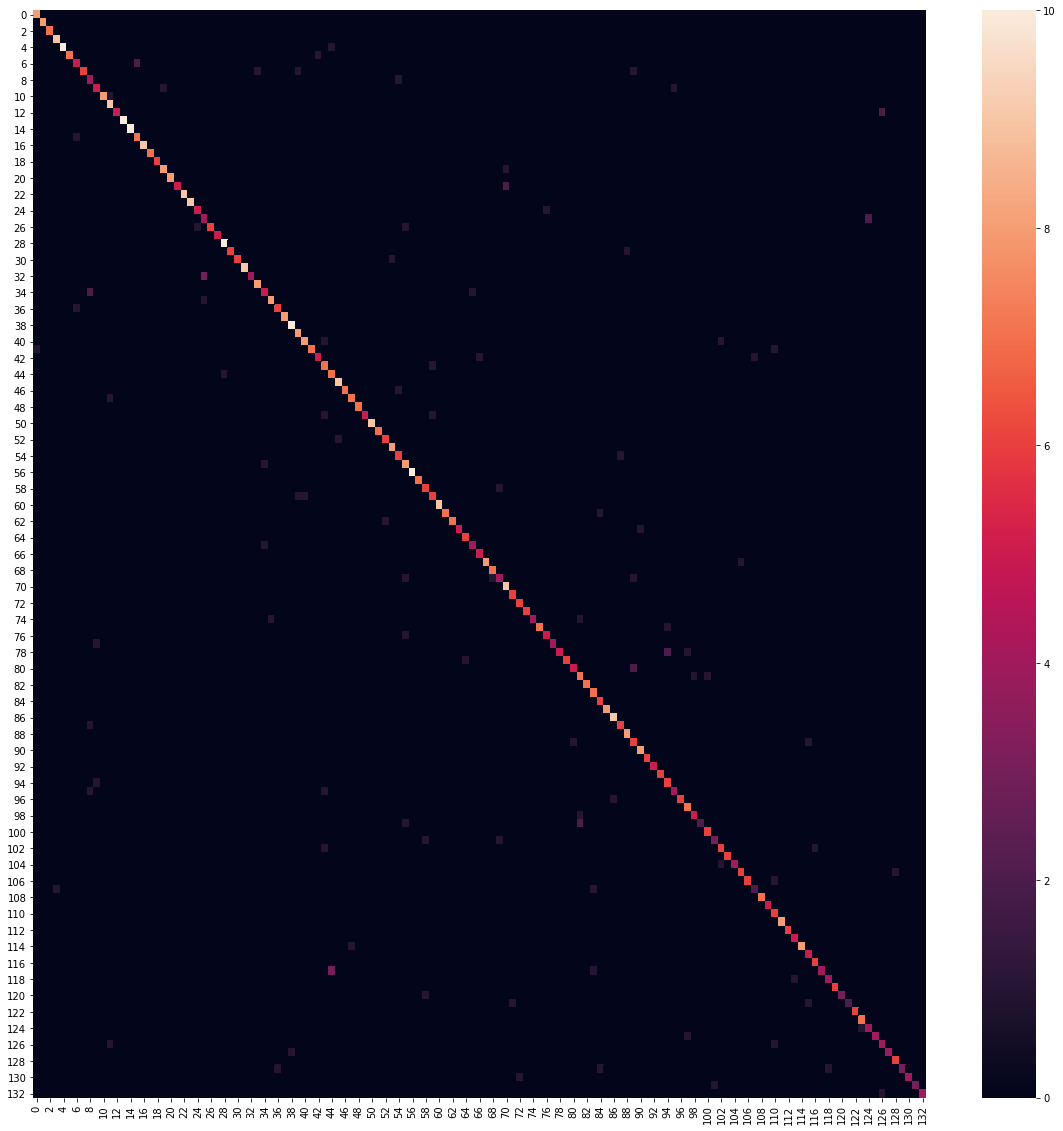

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Evaluate testing set and return predictions for test set 
all_preds, all_true = learner.evaluate(dataloaders['test'], return_preds=True)
# Seaborn Heatmap with confusion_matrix
fig, ax = plt.subplots(figsize=(20,20))       
sns.heatmap(confusion_matrix(all_true, all_preds), ax=ax);

## Deployment

*Generally this will mean deploying a code representation of the model into an operating system to score or categorize new unseen data as it arises and to create a mechanism for the use of that new information in the solution of the original business problem.  Importantly, the code representation must also include all the data prep steps leading up to modeling so that the model will treat new raw data in the same manner as during model development.*

In [40]:
def process_image(image, shape=224):
    """
    Scales, crops, and normalizes a PIL image for a PyTorch model,
    returns an Numpy array
    
    Args:
        image (str): Path to image
        shape (int): Shape of output image 
    Returns:
        image (numpy array): Scaled and processed Numpy array
    """
    image = Image.open(image)
    (h, w) = image.size
    
    means = MEAN_IMAGENET
    stds = STD_IMAGENET

    small_side_index = np.argmin([h, w])
    if small_side_index == 0: 
        height = 256
        r = height / float(h)
        dim = (int(w * r), height)
    else: 
        width = 256
        r = width / float(w)
        dim = (width, int(h * r))
              
    # resize
    resized_image = image.resize(dim, Image.NEAREST)
    # center crop
    center = (dim[0] / 2, dim[1] / 2)
    left = (dim[0] - shape) / 2
    top = (dim[1] - shape) / 2
    right = (dim[0] + shape) / 2
    bottom = (dim[1] + shape) / 2
    resized_image = resized_image.crop((left, top, right, bottom))
    
    # scale image 
    np_image = np.array(resized_image) / 255.
    np_image -= means
    np_image /= stds
    return np.transpose(np_image, (2, 0, 1))


def imshow(image):
    """
    Reverse process and plot Image
    
    Args:
        image (numpy array): 3 dimensional numpy array of image
    Returns:
        None
    """
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))   
    # Undo preprocessing
    mean = np.array(MEAN_IMAGENET)
    std = np.array(STD_IMAGENET)
    image = std * image + mean
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    
def examine_prediction(learner, image, label, cat_to_name=None, topk=5):
    """
    Args:
        learner (object): NN Model Class 
        image (str): Path to image
        label (int): True class label
        cat_to_name (dict): dictionary mapping the actual names of the breeds to integer
        topk (int): Number of Top Classes to Return
    Returns:
        None 
    """
    reverse_map = {y : x for x, y in class_to_idx.items()}    
    plt.figure(figsize=(5, 10))
    probs, classes = learner.predict(image, topk)
    reversed_probs = probs[::-1]
    reversed_classes = classes[::-1]
    class_names = [x.split('.')[-1] for x in reversed_classes]
    # True Image with True 
    plt.subplot(2, 1, 1)
    imshow(process_image(image))
    plt.title(reverse_map[label].split('.')[-1])
    # Bar plot based on predicted probabilities 
    plt.subplot(2, 1, 2)
    y_pos = np.arange(len(class_names))
    plt.barh(y_pos, reversed_probs)
    plt.yticks(y_pos, class_names)
    plt.xlabel('Score')
    plt.title('Top {} Predicted Classes'.format(topk))

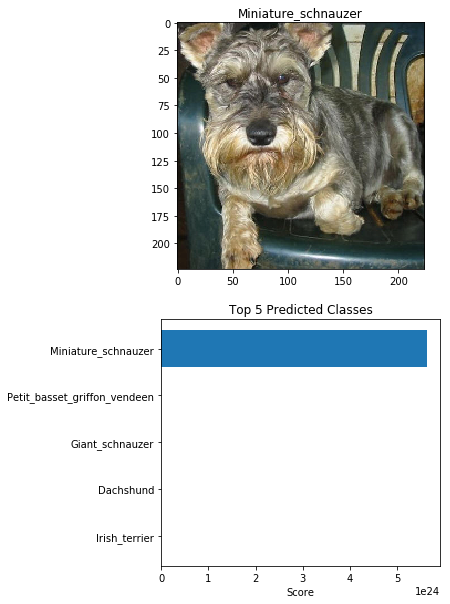

In [43]:
# Randomly sample an image from the testing set 
sample_index = np.random.randint(len(dataloaders['test'].dataset))
img, label = dataloaders['test'].dataset.imgs[sample_index]
# examine prediction -- plot image with 'true' class as title and top 5 predicted classes
examine_prediction(learner, img, label, class_to_idx)

### Next Step
The next step for this project would be to create an 'app' for the model. Maybe something like a simple Flask RESTful app with an endpoint and host it with AWS labmda. Obviously this will depend on the clients' main goal of the application, so we will need to communicate with the client to learn about the ultimite goal of the project. Discussed more below. 

## Additional information

**Additional Information Needed from Client**

- What 'evaluation metric' is most important to achieve? Does the client only care about top1 accuracy? Or topK accuracy of the model? Is the precision of the model more important? Recall? How penaltized are we if we get something wrong? 
- What does the baseline accuracy for the model need to be to be used in production? What does an MVP look like?
- How often will 'new data' come in? How often will we need to re-train the model? Do you have personnel to do this? Or is this all on our side? Online learning? 
- Scaling factor of data? 
- How 'fast' does the prediction need to happen? Is this a real-time prediction app? One prediction at a time? Batch predictions? Is long training time a issue? What kind of resources are available? What is your budget for this project? 
- How will the model be used? Need website endpoint? Internal use? AWS? Flask App? Django?
- 
- If the ultimate goal for the business is to determine the pet’s age, gender, and breed. We should ask the client to also provide us with the age and gender of the dogs for the images as well. Then we can train a 'mult-headed' CNN model to return the breed, age and gender of the dog in question. 

**Additional Improvements in the modeling process**
- Stratified data splitting 
- Freeze layers for model and only tune intermediate res-blocks (see code cell below)
- Learning rate scheduler: [Cosine Annealing](https://arxiv.org/pdf/1608.03983.pdf) or [Triangular LR policy](http://teleported.in/posts/cyclic-learning-rate/) for faster convergance
- [Differential Learning Rates](https://blog.slavv.com/differential-learning-rates-59eff5209a4f)  for Transfer Learning
- Early Stopping
- More hyper-parameter tuning
- Increare image sizes even more 
- Different transfer learning models, Inception, Resnext, etc...
- Need to run model again on the entire training set dataset
- Analyze incorrectly predicted images and see if we can help the model out

## Extra 
### Next Iteration of model

We can freeze certain layers for the model. For example, we first train only the final fully connected layers, then train only the last few resnet blocks, etc... Worth a try, but this dataset is too similar to the image trained on ImageNet, so the pre-trained weights of the conv layers are probably fine.

In [ ]:
# Model helpers
def children(model): 
    """Get children (layers) from model"""
    return model if isinstance(model, (list, tuple)) else list(model.children())

def set_trainable_attr(model, b):
    """Set parameters of model be trainable or not trainable"""
    model.trainable = b
    for p in model.parameters(): 
        p.requires_grad = b

def apply_leaf(model, f):
    """Apply a function (f) to children of model"""
    c = children(model)
    if isinstance(model, nn.Module): 
        f(model)
    if len(c) > 0:
        for l in c: apply_leaf(l, f)

def set_trainable(l, b):
    """Set layer as trainable or not trainable"""
    apply_leaf(l, lambda model: set_trainable_attr(model, b))
      
def split_by_idxs(seq, idxs):
    """
    A generator that returns sequence pieces
    seperated by indexes specified in idxs
    """
    last = 0
    for idx in idxs:
        if not (-len(seq) <= idx < len(seq)):
            raise KeyError('Idx {} is out-of-bounds'.format(idx))
        yield seq[last:idx]
        last = idx
    yield seq[last:]
    

# Training helpers 
def apply_to_tensor(input_, func):
    """
    Apply a function on a tensor or mapping, or sequence of tensors.
    """
    return apply_to_type(input_, torch.Tensor, func)

def apply_to_type(input_, input_type, func):
    """
    Apply a function on a object of `input_type` or mapping, or sequence of objects of `input_type`.
    """
    if isinstance(input_, input_type):
        return func(input_)
    elif isinstance(input_, string_classes):
        return input_
    elif isinstance(input_, collections.Mapping):
        return {k: apply_to_type(sample, input_type, func) for k, sample in input_.items()}
    elif isinstance(input_, collections.Sequence):
        return [apply_to_type(sample, input_type, func) for sample in input_]
    else:
        raise TypeError(("input must contain {}, dicts or lists; found {}"
                         .format(input_type, type(input_))))


def convert_tensor(input_, device=None, non_blocking=False):
    """
    Move tensors to relevant device.
    """
    def _func(tensor):
        return tensor.to(device=device, non_blocking=non_blocking) if device else tensor

    return apply_to_tensor(input_, _func)

def _prepare_batch(batch, device=None, non_blocking=False):
    """
    Prepare batch for training: pass to a device with options
    """
    x, y = batch
    return (convert_tensor(x, device=device, non_blocking=non_blocking),
            convert_tensor(y, device=device, non_blocking=non_blocking))



all_lr = []

def create_supervised_trainer(model, optimizer, loss_fn, scheduler=None,
                              device=None, non_blocking=False,
                              prepare_batch=_prepare_batch):
    if device:
        model.to(device)

    def _update(engine, batch):
        model.train()
        optimizer.zero_grad()
        x, y = prepare_batch(batch, device=device, non_blocking=non_blocking)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        for param_group in optimizer.param_groups:
            all_lr.append(param_group['lr'])
        # scheduler
        if scheduler: scheduler.step()
        return loss.item()

    return Engine(_update)

        



class ResNetModelFreeze(nn.Module):
        
    def __init__(self, K, cut=-2):
        super().__init__()
        resnet = resnet50(pretrained=True)
        
        layers = [*list(resnet.children())[:4]]
        
        # Add other bottleneck layers 
        for i, mod in enumerate(list(resnet.children())):
            if isinstance(mod, nn.Sequential):
                for bn in mod:
                    layers += [bn] 
        
        layers += [nn.AdaptiveAvgPool2d(1), Flatten()]
        # create top model 
        self.top_model = nn.Sequential(*layers)
        # create fc model 
        fc_layers = [nn.Linear(2048, K)]
        self.fc_model = nn.Sequential(*(fc_layers))
        # all combined model 
        self.model = nn.Sequential(*(layers+fc_layers))

    def forward(self, X):
        return self.model(X)
    

class NNModel():
    # ADD to NNModel class 
    def freeze_to(self, n):
        c = self.get_layer_groups()
        for l in c:     set_trainable(l, False)
        for l in c[n:]: set_trainable(l, True)
    
    def unfreeze(self): 
        self.freeze_to(0)
        
    def freeze(self):
        self.freeze_to(-1)
        
    def get_layer_groups(self, do_fc=False):
        cut, self.lr_cut = [8, 6]
        if do_fc:
            return [self.model.fc_model]
        idxs = [self.lr_cut]
        c = children(self.model.top_model)
        if len(c) == 3: 
            c = children(c[0]) + c[1:]
        lgs = list(split_by_idxs(c, idxs))
        return lgs + [self.model.fc_model]